# Comparing evaluation metrics across model types for all donors
Contains the following figures:
* Fig. S3a and S3b
* Fig. 4b and 4d

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import Levenshtein as Lev
import statsmodels.discrete.discrete_model as dm
import scipy.optimize
import scipy.stats as st

import os
import warnings
from datetime import datetime

# Load in custom functions
from MM_functions import model_fit_functions as ff

# Edit to reflect your own repository location
path = './'
os.chdir(path)

# Whether or not to save figures
save = True # False

date = datetime.today().strftime('%Y-%m-%d')
print(date)

2023-10-17


### Loading data

In [2]:
# Loading in files from preprocessing notebook into dictionary

donor_files = os.listdir('./data/processed/donor_cells')
donor_file_dict = dict(zip(list(range(1,len(donor_files) + 1)), donor_files))

donor_dfs = {}
for donor in donor_file_dict:
    donor_dfs[donor] = pd.read_csv('./data/processed/donor_cells/' + donor_file_dict[donor], sep = ',', index_col=0)

In [3]:
# Loading in files from preprocessing notebook into dictionary

vrc01_files = os.listdir('./data/processed/vrc01_cells')
vrc01_file_dict = dict(zip(list(range(1,len(vrc01_files) + 1)), vrc01_files))

vrc01_dfs = {}
for donor in vrc01_file_dict:
    vrc01_dfs[donor] = pd.read_csv('./data/processed/vrc01_cells/' + vrc01_file_dict[donor], sep = ',', index_col=0)

In [4]:
lss_names = [col for col in donor_dfs[1].columns if '.LSS' in col]
umi_names = [i.split('.')[0] for i in lss_names]

### Functions

In [5]:
def log_like_mix_poisson(n, mu1, mu2, w):
    """Log-likeihood of binary Negative Binomial mixture model."""
    # Fix nonidentifieability be enforcing values of w
    if w < 0 or w > 1:
        return -np.inf

    # Physical bounds on parameters
    if mu1 < 0 or mu2 < 0:
        return -np.inf

    logx1 = st.poisson.logpmf(n, mu1)
    logx2 = st.poisson.logpmf(n, mu2)

    # Multipliers for log-sum-exp
    lse_coeffs = np.tile([w, 1-w], [len(n), 1]).transpose()

    # log-likelihood for each measurement
    log_likes = scipy.special.logsumexp(np.vstack([logx1, logx2]), axis=0, b=lse_coeffs)

    return np.sum(log_likes)

def log_like_iid_nbinom_poisson(params, n):
    """Log likelihood for i.i.d. NBinom measurements, parametrized
    by alpha, b=1/beta."""
    mu = params

    if mu <= 0:
        return -np.inf
    
    return np.sum(st.poisson.logpmf(n, mu))


def mle_mix_poisson(n, initials):
    """Obtain MLE estimate for parameters for binary mixture of Poisson distributions."""
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        res = scipy.optimize.minimize(
            fun=lambda params, n: -log_like_mix_poisson(n, *params),
            x0=[*initials],
            args=(n,),
            method='Powell',
            tol=1e-4)

    if res.success:
        return res
    else:
        res.x = np.nan
        return res

# Needed a function bc we have to calculate BIC manually
def normal_dist_BIC(fit_model, x_noise):
    # BIC for normal
    norm_mean, norm_std = fit_model[0], fit_model[1]
    n_samples = len(x_noise)
    n_params = 2  # Two parameters: mean and standard deviation
    log_likelihood = np.sum(st.norm.logpdf(x_noise, loc=norm_mean, scale=norm_std))
    bic = -2 * log_likelihood + n_params * np.log(n_samples)

    return bic

# Loglikelihood for Mixed normal model
def log_like_mix_gaussian(n, mean1, std1, mean2, std2, w):
    """Log-likeihood of binary Negative Binomial mixture model."""
    # Fix nonidentifieability be enforcing values of w
    if w < 0 or w > 1:
        return -np.inf

    # Physical bounds on parameters
    if mean1 < 0 or mean2 < 0:
        return -np.inf

    logx1 = st.norm.logpdf(n, mean1, std1)
    logx2 = st.norm.logpdf(n, mean2, std2)

    # Multipliers for log-sum-exp
    lse_coeffs = np.tile([w, 1-w], [len(n), 1]).transpose()

    # log-likelihood for each measurement
    log_likes = scipy.special.logsumexp(np.vstack([logx1, logx2]), axis=0, b=lse_coeffs)

    return np.sum(log_likes)

def mle_mix_gaussian(n, initials):
    """Obtain MLE estimate for parameters for binary mixture of Poisson distributions."""
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        res = scipy.optimize.minimize(
            fun=lambda params, n: -log_like_mix_gaussian(n, *params),
            x0=[*initials],
            args=(n,),
            method='Powell',
            tol=1e-4)

    if res.success:
        return res
    else:
        res.x = np.nan
        return res

### Loop for testing different types of noise ditributions across donors for SARS-2

In [72]:
import statsmodels.discrete.discrete_model as dm

umi = 'SARS-2'

model_BICs = {}

model_metrics = {}
for donor in vrc01_dfs:
    sample_BICs = {}
    if donor != 3:
        x_noise = (vrc01_dfs[donor][umi])
        X_noise = np.ones_like(x_noise)

        model_noise_poisson = dm.Poisson(x_noise,X_noise).fit(start_params=[1])
        model_noise_nBinom = dm.NegativeBinomial(x_noise,X_noise).fit(start_params=[1,1])
        model_noise_norm = st.norm.fit(x_noise)
        
        model_metrics['Poisson'] = model_noise_poisson.params
        model_metrics['nBinom'] = model_noise_nBinom.params
        model_metrics['Gaussian'] = model_noise_norm

        sample_BICs['nBinom'] = model_noise_nBinom.bic
        sample_BICs['Poisson'] = model_noise_poisson.bic
        sample_BICs['Gaussian'] = normal_dist_BIC(model_noise_norm, x_noise)

        model_BICs[donor] = sample_BICs

Optimization terminated successfully.
         Current function value: 2.094321
         Iterations 4
Optimization terminated successfully.
         Current function value: 2.043520
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 3.679569
         Iterations 10
Optimization terminated successfully.
         Current function value: 3.295654
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 2.056530
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.897020
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 2.230163
         Iterations 4
Optimization terminated successfully.
         Current function value: 2.145772
 

In [11]:
sns.set(rc = {'figure.figsize':(6.82,5), 'axes.facecolor':'white', 'figure.facecolor':'white', 'axes.edgecolor': 'black',  'axes.spines.right': True, 'axes.spines.top': True, 'axes.linewidth': 1, 'axes.grid':True}, font_scale=1.5, palette='Set2')
bic_palette = [sns.palettes.get_color_cycle()[0], 'grey', sns.palettes.get_color_cycle()[1]]


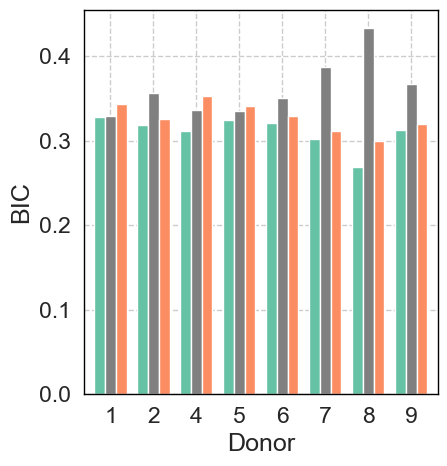

In [74]:

sns.set(rc = {'figure.figsize':(4.82,5),
          'axes.facecolor':'white', 'figure.facecolor':'white', 'axes.edgecolor': 'black',  'axes.spines.right': True,
          'axes.spines.top': True, 'axes.linewidth': 1, 'axes.grid':True}, font_scale=1.5, palette=bic_palette)


sns.set_style("whitegrid", {
    "ytick.major.size": 0.1,
    "ytick.minor.size": 0.05,
    'grid.linestyle': '--', 'axes.edgecolor': 'black', 'axes.spines.right': True,
          'axes.spines.top': True
 })

bic_df = pd.DataFrame(model_BICs)
bic_df.columns.name='Donor'
bic_df = bic_df.sort_index(ascending=False)

(bic_df / bic_df.sum()).T.plot.bar(width=0.75, rot=0, legend=False)
plt.ylabel('BIC')

# plt.legend(bbox_to_anchor=(0.5,0.3))

plt.tight_layout()

if save:
    plt.savefig('figS3a.svg')

## Loop for mixed models

In [8]:
umi = 'SARS-2'
w_guess = 0.1

model_BICs = {}
model_metrics = {}
for donor in donor_dfs:
    sample_BICs = {}
    sample_metrics = {}

    x_signal = (donor_dfs[donor][umi])

    x_noise = (vrc01_dfs[donor][umi])
    X_noise = np.ones_like(x_noise)

    # For samples with VRC01
    if len(x_noise > 0):
        model_noise_poisson = dm.Poisson(x_noise,X_noise).fit(start_params=[1])
        mu_noise = model_noise_poisson.params[0]
        model_noise_nb = dm.NegativeBinomial(x_noise,X_noise).fit(start_params=[1,1])
        model_noise_norm = st.norm.fit(x_noise)

        # Mixed Poisson MLE
        initials = (1, mu_noise, w_guess)
        poisson_mixture = mle_mix_poisson(x_signal, initials)
        
        # Mixed normal MLE
        norm_mean, norm_std = model_noise_norm[0], model_noise_norm[1]
        initials = (1, 1, norm_mean, norm_std, w_guess)
        gaussian_mixture = mle_mix_gaussian(x_signal, initials)

        # nBinomial MLE
        mu_noise = np.exp(model_noise_nb.params[0])
        n_noise = 1/model_noise_nb.params[1]
        p_noise = n_noise/(n_noise + mu_noise)
        noise_param2 = (1/p_noise)-1 

        nBinom_mixture = ff.custom_mle_mix(x_signal, w_guess = w_guess, initials = (1,1,n_noise,noise_param2))
        
    # Samples without VRC01
    else:

        # Mixed Poisson MLE
        initials = (1, 1, w_guess)
        poisson_mixture = mle_mix_poisson(x_signal, initials)

        # Mixed normal MLE
        initials = (1, 1, 1, 1, w_guess)
        gaussian_mixture = mle_mix_gaussian(x_signal, initials)

        # nBinomial MLE
        nBinom_mixture = ff.custom_mle_mix(x_signal, w_guess = w_guess, initials = (1,1,1,1))

    sample_BICs['Poisson'] = poisson_mixture.fun
    sample_metrics['Poisson'] = poisson_mixture.x

    sample_BICs['Gaussian'] = gaussian_mixture.fun
    # In case normal doesn't converge, setting to 0 only for plotting purposes
    if gaussian_mixture.success == False:
        sample_BICs['Gaussian'] = 0
    sample_metrics['Gaussian'] = gaussian_mixture.x

    sample_BICs['nBinom'] = int(nBinom_mixture.fun)
    sample_metrics['nBinom'] = nBinom_mixture.x

    model_BICs[donor] = sample_BICs
    model_metrics[donor] = sample_metrics

Optimization terminated successfully.
         Current function value: 2.094321
         Iterations 4
Optimization terminated successfully.
         Current function value: 2.043520
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 3.679569
         Iterations 10
Optimization terminated successfully.
         Current function value: 3.295654
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 2.056530
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.897020
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 2.230163
         Iterations 4
Optimization terminated successfully.
         Current function value: 2.145772
 

### Fig. S3

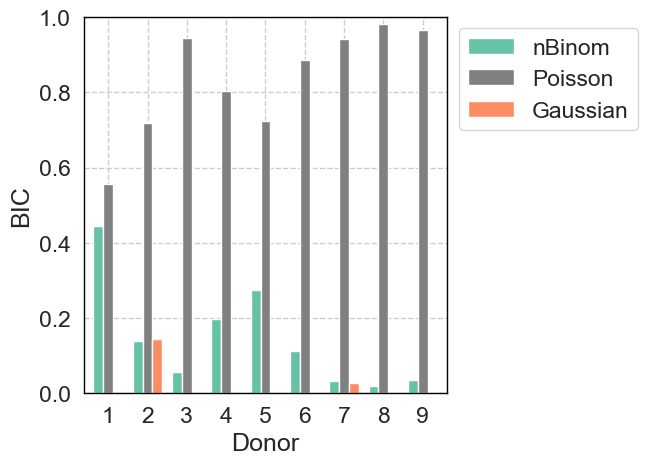

In [76]:
sns.set(rc = {'figure.figsize':(6.82,5), 'axes.facecolor':'white', 'figure.facecolor':'white', 'axes.edgecolor': 'black',  'axes.spines.right': True, 'axes.spines.top': True, 'axes.linewidth': 1, 'axes.grid':True}, font_scale=1.5, palette=bic_palette)
sns.set_style("whitegrid", {"ytick.major.size": 0.1, "ytick.minor.size": 0.05, 'grid.linestyle': '--', 'axes.edgecolor': 'black', 'axes.spines.right': True, 'axes.spines.top': True})

model_BIC_df = pd.DataFrame(model_BICs)
model_BIC_df.columns.name = 'Donor'
model_BIC_df = model_BIC_df.sort_index(ascending=False)

(model_BIC_df / model_BIC_df.sum()).T.plot.bar(width=0.75, rot=0)

plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1,1))

plt.ylabel('BIC')
# plt.title('SARS-2 Mixed Model Fits')
plt.tight_layout()

if save:
    plt.savefig('figS3b.svg')

### Fig. 4d

In [77]:
model_BIC_df.drop('Gaussian', axis=0, inplace=True)

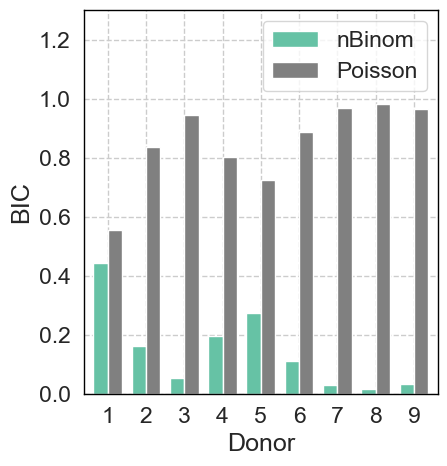

In [78]:
sns.set(rc = {'figure.figsize':(4.82,5), 'axes.facecolor':'white', 'figure.facecolor':'white', 'axes.edgecolor': 'black',  'axes.spines.right': True, 'axes.spines.top': True, 'axes.linewidth': 1, 'axes.grid':True}, font_scale=1.5, palette=bic_palette)
sns.set_style("whitegrid", {"ytick.major.size": 0.1, "ytick.minor.size": 0.05, 'grid.linestyle': '--', 'axes.edgecolor': 'black', 'axes.spines.right': True, 'axes.spines.top': True})


(model_BIC_df / model_BIC_df.sum()).T.plot.bar(width=0.75, rot=0)

plt.ylim(0,1.3)
plt.legend(bbox_to_anchor=(1,1))

plt.ylabel('BIC')
# plt.title('SARS-2 Mixed Model Fits')
plt.tight_layout()

if save:
    plt.savefig('fig4d_23-10-02.svg')

--------------------------------

### Fig. 4a

In [79]:
# Get metrics for mixture models for Donor 2
model_metrics[2]

{'Poisson': array([8.68807319e+02, 1.59444767e+01, 8.84789783e-02]),
 'Gaussian': array([ 12.7007089 ,   6.27628855, 616.47810276, 563.4004774 ,
          0.86966414]),
 'nBinom': array([8.19480587e-01, 7.55523422e+02, 6.11013100e+00, 2.09127216e+00,
        1.34331482e-01])}

In [9]:
# Calculate cumulative distribution functions for each type of mixture model

x_signal = (donor_dfs[2][umi])

# Poisson CDF
mu1, mu2, w_p = model_metrics[2]['Poisson']
n_theor = np.arange(0, x_signal.max()+1)
cdf_theor_p = w_p * st.poisson.cdf(n_theor, mu1)
cdf_theor_p += (1 - w_p) * st.poisson.cdf(n_theor, mu2)

# Gaussian CDF
alpha1_mle, b1_mle, alpha2_mle, b2_mle, w_mle = model_metrics[2]['Gaussian']
n_theor = np.arange(0, x_signal.max()+1)
cdf_theor_n = w_mle * st.norm.cdf(n_theor, alpha1_mle, b1_mle)
cdf_theor_n += (1 - w_mle) * st.norm.cdf(n_theor, alpha2_mle, b2_mle)

# nBinom CDF
alpha1_mle, b1_mle, alpha2_mle, b2_mle, w_mle = model_metrics[2]['nBinom']
n_theor = np.arange(0, x_signal.max()+1)
cdf_theor = w_mle * st.nbinom.cdf(n_theor, alpha1_mle, 1/(1+b1_mle))
cdf_theor += (1 - w_mle) * st.nbinom.cdf(n_theor, alpha2_mle, 1/(1+b2_mle))

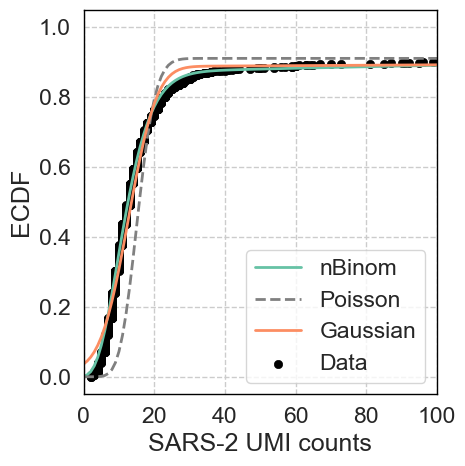

In [15]:
# Plotting CDFs

sns.set(rc = {'figure.figsize':(5,5), 'axes.facecolor':'white', 'figure.facecolor':'white', 'axes.edgecolor': 'black',  'axes.spines.right': True, 'axes.spines.top': True, 'axes.linewidth': 1, 'axes.grid':True}, font_scale=1.5, palette=bic_palette)
sns.set_style("whitegrid", {"ytick.major.size": 0.1, "ytick.minor.size": 0.05, 'grid.linestyle': '--', 'axes.edgecolor': 'black', 'axes.spines.right': True, 'axes.spines.top': True})


sns.lineplot(cdf_theor, label='nBinom', linewidth=2) #, color='dodgerblue')
sns.lineplot(cdf_theor_p, label='Poisson', linewidth=2,linestyle='--') #, color='tan')
sns.lineplot(cdf_theor_n, label='Gaussian', linewidth=2) #, color='aqua')

# sns.ecdfplot(data=x_signal, label='Data', color='black', linewidth=1.5)
# sns.lineplot(data=sorted(x_signal), marker='o', drawstyle='steps-post', alpha=0.5, color='black', linewidth=2)

sns.scatterplot(x = np.sort(x_signal), y = np.linspace(0, 1, len(x_signal)),color='black',  label='Data', edgecolor='black')
plt.xlim(0,100)
plt.legend()

plt.ylabel('ECDF')
plt.xlabel('SARS-2 UMI counts')
plt.tight_layout()

if save:
    plt.savefig('fig4b.svg')